In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import anndata as ad
import itertools
#import alphashape
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set number of neighbors in smoothing
num_neigh = 20

## PBMC

In [3]:
rna = sc.read_h5ad("10XMultiome_GEX.PBMC.h5ad")
rna_siaNN = rna.copy()
rna_siaNN.obsm['X_pca'] = rna_siaNN.obsm['SiaNN']
sc.pp.neighbors(rna_siaNN, n_neighbors=num_neigh)
x = np.ravel(rna_siaNN.obsp['distances'].toarray())
x = x[x > 0]
t = np.percentile(x, 95)

d1 = rna_siaNN.obsp['distances']
d1[d1 > t] = 0

c1 = rna_siaNN.obsp['connectivities']
c1[d1 > t] = 0

c1[c1 > 0] = 1 # no weighted
c1.setdiag(1)

rna_siaNN.obsp['connectivity'] = c1
rna_siaNN.obsp['distances'] = d1

rna_siaNN.layers['smoothed_counts'] = c1 * rna_siaNN.layers['counts']

rna_siaNN.layers['original_log1p'] = rna_siaNN.X.copy()
rna_siaNN.layers['original_counts'] = rna.layers['counts'].copy()
rna_siaNN.X = rna_siaNN.layers['smoothed_counts'].copy()

/mnt/hdd/chaozhong/pylib/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
rna_siaNN.write_h5ad('10XMultiome_GEX.PBMC.smoothed.%sNN.h5ad'%(num_neigh))

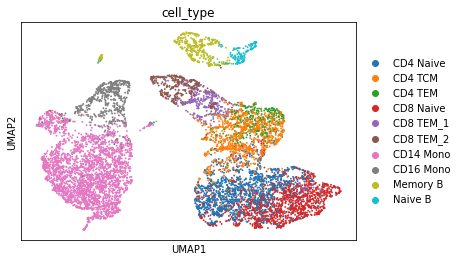

In [5]:
sc.pp.normalize_total(rna_siaNN)
sc.pp.log1p(rna_siaNN)
sc.pp.pca(rna_siaNN)
sc.pp.neighbors(rna_siaNN, n_neighbors=10)
sc.tl.umap(rna_siaNN)
sc.pl.umap(rna_siaNN, color=['cell_type'])

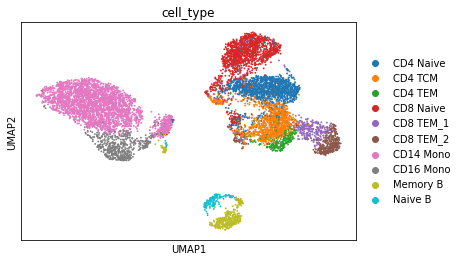

In [6]:
sc.pp.pca(rna, n_comps=30)
sc.pp.neighbors(rna, n_neighbors=10)
sc.tl.umap(rna)
sc.pl.umap(rna, color=['cell_type'])

## ATAC

In [7]:
atac = sc.read_h5ad("10XMultiome_ATAC.PBMC.h5ad")
atac

AnnData object with n_obs × n_vars = 8798 × 106056
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'seurat_annotations', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'ATAC_snn_res.0.8', 'seurat_clusters', 'cell_type'
    obsm: 'SiaNN'

In [8]:
atac_siaNN = atac.copy()
atac_siaNN.obsm['X_pca'] = atac_siaNN.obsm['SiaNN']

sc.pp.neighbors(atac_siaNN, n_neighbors=num_neigh)
x = np.ravel(atac_siaNN.obsp['distances'].toarray())
x = x[x > 0]
t = np.percentile(x, 95)

d1 = atac_siaNN.obsp['distances']
d1[d1 > t] = 0

c1 = atac_siaNN.obsp['connectivities']
c1[d1 > t] = 0

c1[c1 > 0] = 1 # no weighted
c1.setdiag(1)

atac_siaNN.obsp['connectivity'] = c1
atac_siaNN.obsp['distances'] = d1

smooth_atac_counts = c1 * atac.X

smooth_atac_bins = smooth_atac_counts.copy()

smooth_atac_bins[smooth_atac_counts > 0] = 1

atac_siaNN.layers['smoothed_counts'] = smooth_atac_counts
atac_siaNN.layers['original_counts'] = atac_siaNN.X.copy()

atac_siaNN.X = smooth_atac_bins


/mnt/hdd/chaozhong/pylib/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
atac_siaNN.write_h5ad('10XMultiome_ATAC.PBMC.smoothed.%sNN.h5ad'%(num_neigh))

In [10]:
print(np.sum(atac.X > 0) / np.product(atac.shape)), print(np.sum(atac_siaNN.X > 0) / np.product(atac.shape))


0.0724196908895836
0.44242729842030554


(None, None)